# RNA-seq Analysis
Author: Nathaly Keith

Objective: Provide a concise pipeline for RNA-seq counts: QC, normalization, PCA and basic differential testing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style='whitegrid', context='notebook')
%matplotlib inline

In [2]:
# Synthetic count matrix: genes x samples
np.random.seed(1)
genes = [f'Gene{i}' for i in range(1,201)]  # 200 genes
samples = ['Ctrl1','Ctrl2','Ctrl3','Treat1','Treat2','Treat3']
# baseline expressions and a subtle treatment effect for first 10 genes
base = np.random.poisson(lam=50, size=(len(genes), len(samples)))
for g in range(10):
    base[g,3:] = base[g,3:] + np.random.poisson(lam=20, size=3)  # increase in treatment
counts = pd.DataFrame(base, index=genes, columns=samples)
counts.iloc[:5,:5]

,Ctrl1,Ctrl2,Ctrl3,Treat1,Treat2
Gene1,48,41,43,70,66
Gene2,41,46,38,55,85
Gene3,54,45,39,79,65
Gene4,50,51,52,60,71
Gene5,53,65,61,58,68


## Normalization (TPM-like, simple RPKM approach for demonstration)
We will perform a simple library-size normalization and log-transform for visualization.

In [3]:
# library size normalization (counts per million)
lib_sizes = counts.sum(axis=0)
cpm = counts.div(lib_sizes, axis=1) * 1e6
log_cpm = np.log2(cpm + 1)
log_cpm.iloc[:5,:5]

,Ctrl1,Ctrl2,Ctrl3,Treat1,Treat2
Gene1,12.238525,12.004503,12.059679,12.752864,12.679983
Gene2,12.011166,12.170475,11.881386,12.404998,13.044931
Gene3,12.408417,12.138773,11.918851,12.927338,12.657960
Gene4,12.297407,12.319308,12.333796,12.530506,12.785321
Gene5,12.381455,12.669189,12.564052,12.481605,12.723046


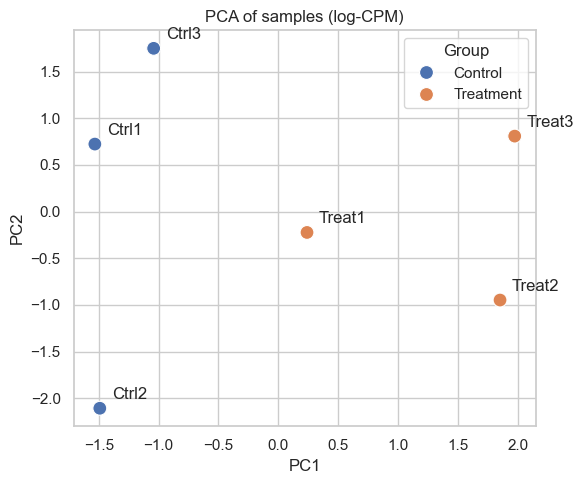

In [4]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(log_cpm.T)  # transpose -> samples x genes
pc_df = pd.DataFrame(pcs, index=log_cpm.columns, columns=['PC1','PC2'])
pc_df['Group'] = ['Control']*3 + ['Treatment']*3

plt.figure(figsize=(6,5))
sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pc_df, s=100)
plt.title('PCA of samples (log-CPM)')
for i, txt in enumerate(pc_df.index):
    plt.annotate(txt, (pc_df['PC1'].iloc[i]+0.1, pc_df['PC2'].iloc[i]+0.1))
plt.tight_layout()

## Quick differential analysis
A fully correct RNA-seq DE requires tools like DESeq2/edgeR (R). Here we illustrate a simple linear model per gene as a didactic example.

In [5]:
# build a sample metadata table
meta = pd.DataFrame({
    'sample': log_cpm.columns,
    'group': ['Control','Control','Control','Treatment','Treatment','Treatment']
}).set_index('sample')

# fit a linear model gene-by-gene: expression ~ group
results = []
for gene in log_cpm.index:
    df = pd.DataFrame({
        'expr': log_cpm.loc[gene],
        'group': meta['group']
    })
    model = smf.ols('expr ~ C(group)', data=df).fit()
    pval = model.pvalues.get('C(group)[T.Treatment]', np.nan)
    fold = df[df['group']=='Treatment']['expr'].mean() - df[df['group']=='Control']['expr'].mean()
    results.append((gene, fold, pval))
res_df = pd.DataFrame(results, columns=['gene','log2FC','pvalue']).set_index('gene')
res_df['adj_pvalue'] = sm.stats.multipletests(res_df['pvalue'].fillna(1), method='fdr_bh')[1]
res_df.sort_values('adj_pvalue').head(10)

,log2FC,pvalue,adj_pvalue
gene,,,
Gene1,0.624222,0.001093,0.202951
Gene90,-0.297025,0.002030,0.202951
Gene29,0.238686,0.003938,0.262523
Gene31,0.418824,0.008511,0.340439
Gene49,0.288002,0.007148,0.340439
Gene27,-0.274696,0.012048,0.363431
Gene6,0.256833,0.012720,0.363431
Gene107,0.402527,0.015395,0.384875
Gene10,0.607411,0.030561,0.402600


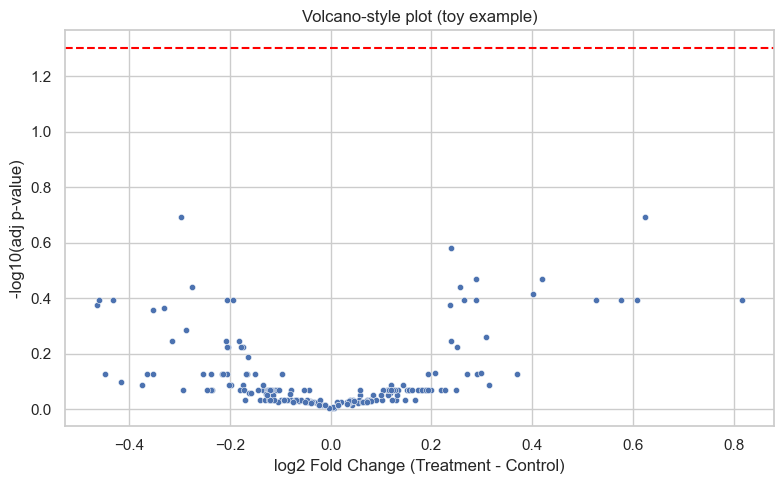

In [6]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='log2FC', y=-np.log10(res_df['adj_pvalue']), data=res_df, s=20)
plt.xlabel('log2 Fold Change (Treatment - Control)')
plt.ylabel('-log10(adj p-value)')
plt.title('Volcano-style plot (toy example)')
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.tight_layout()

## Notes
- This notebook is educational: for real differential expression analysis use specialized packages (DESeq2 or edgeR).
- Replace synthetic data with your counts CSV: `pd.read_csv("counts.csv", index_col=0)`